In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Bird Audio Classification

/content/drive/MyDrive/Bird Audio Classification


In [ ]:
pwd

'/content/drive/MyDrive/Bird Audio Classification'

In [ ]:
ls

 BirdAudioDataset/                'Deep Audio Classification.ipynb'
 capuchin_audio_classifier_e4.h5


In [ ]:
pip install tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 35.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten
from keras.metrics import Accuracy, Recall, Precision
from itertools import groupby

Load Data

In [ ]:
capuchin_file = '/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Parsed_Capuchinbird_Clips/XC600460-4.wav'
non_capuchin_file = '/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Parsed_Not_Capuchinbird_Clips/sparrow-sound-effect-51.wav'

In [ ]:
def load_wav_16k_mono(filename):
  file_content = tf.io.read_file(filename)
  wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)

  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)

  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

Plot Wave

In [ ]:
wave_c = load_wav_16k_mono(capuchin_file)
wave_nc = load_wav_16k_mono(non_capuchin_file)

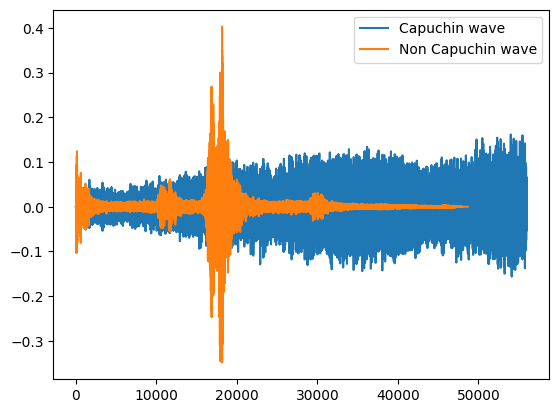

In [ ]:
plt.plot(wave_c, label = 'Capuchin wave')
plt.plot(wave_nc, label = 'Non Capuchin wave')
plt.legend()
plt.show()

In [ ]:
positive_path = '/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Parsed_Capuchinbird_Clips'
negative_path = '/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Parsed_Not_Capuchinbird_Clips'

In [ ]:
positive = tf.data.Dataset.list_files(positive_path+'/*.wav')
negative = tf.data.Dataset.list_files(negative_path+'/*.wav')

In [ ]:
positive.as_numpy_iterator().next()

b'/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Parsed_Capuchinbird_Clips/XC574020-0.wav'

In [ ]:
len(positive)

217

In [ ]:
negative.as_numpy_iterator().next()

b'/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Parsed_Not_Capuchinbird_Clips/robin-chirping-10.wav'

In [ ]:
len(negative)

593

Add Labels to data

In [ ]:
positives = tf.data.Dataset.zip((positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(positive)))))
negatives = tf.data.Dataset.zip((negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative)))))

In [ ]:
positives.as_numpy_iterator().next()

(b'/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Parsed_Capuchinbird_Clips/XC227469-4.wav',
 1.0)

In [ ]:
negatives.as_numpy_iterator().next()

(b'/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Parsed_Not_Capuchinbird_Clips/cricket-sounds-for-sleep-0.wav',
 0.0)

In [ ]:
#Create a shuffled dataset with both positive and negative data
dataset = positives.concatenate(negatives)
dataset = dataset.shuffle(1000)

In [ ]:
len(dataset)

810

Check Average Length of Capuchin Sounds

In [ ]:
lengths = []
for file in positive:
  tensor_wave = load_wav_16k_mono(file);
  lengths.append(len(tensor_wave))

In [ ]:
lengths[:10]

[48000, 48000, 40000, 48000, 64000, 56000, 56000, 56000, 56000, 48000]

In [ ]:
min(lengths)

32000

In [ ]:
max(lengths)

80000

In [ ]:
np.mean(lengths)

54156.66359447005

In [ ]:
print('Min length in seconds: ',min(lengths)/16000)
print('Max length in seconds: ',max(lengths)/16000)
print('Average length in seconds: ',np.mean(lengths)/16000)

Min length in seconds:  2.0
Max length in seconds:  5.0
Average length in seconds:  3.384791474654378


Preprocessing: Convert to Spectrogram

In [ ]:
def preprocess(file_path, label):
  wav = load_wav_16k_mono(file_path)
  wav = wav[:48000]
  zero_padding = tf.zeros([48000]-tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav], 0)
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32) #See what does this do
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2) #Adding a channel dimension
  return spectrogram, label

In [ ]:
spectrogram, label = preprocess(capuchin_file, 1.0)

In [ ]:
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[1.9848382e-01],
        [1.7799576e-01],
        [1.3361290e-01],
        ...,
        [8.7591281e-05],
        [2.6599511e-05],
        [4.0307641e-06]],

       [[1.9323125e-01],
        [1.7373024e-01],
        [1.2358694e-01],
        ...,
        [9.5478812e-05],
        [4.7609796e-05],
        [6.1169267e-06]],

       [[1.6765618e-01],
        [1.4076592e-01],
        [9.4790876e-02],
        ...,
        [9.3024173e-05],
        [5.1854870e-05],
        [3.6470592e-05]],

       ...,

       [[2.2437301e-01],
        [1.9192766e-01],
        [1.5562695e-01],
        ...,
        [4.3272936e-05],
        [5.2552678e-05],
        [4.2095780e-06]],

       [[2.1720138e-01],
        [1.6670543e-01],
        [1.1108949e-01],
        ...,
        [2.7335243e-05],
        [4.7279580e-05],
        [6.2972307e-05]],

       [[2.1901622e-01],
        [1.4325589e-01],
        [2.9564580e-02],
        ...,
        [4.5652574

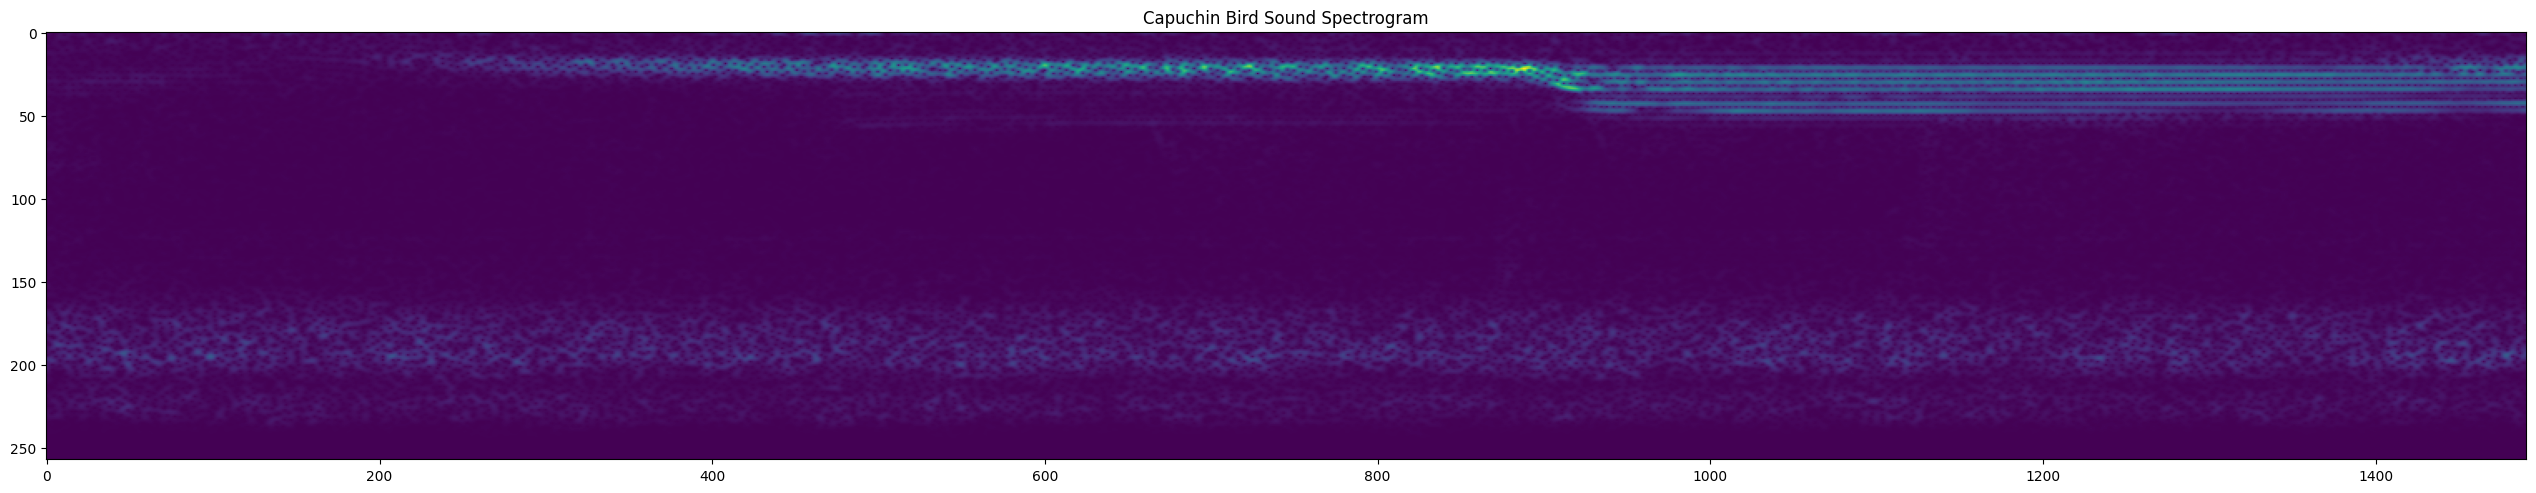

In [ ]:
plt.figure(figsize=(32,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.title("Capuchin Bird Sound Spectrogram")
plt.show()

In [ ]:
spectrogram, label = preprocess(non_capuchin_file, 1.0)

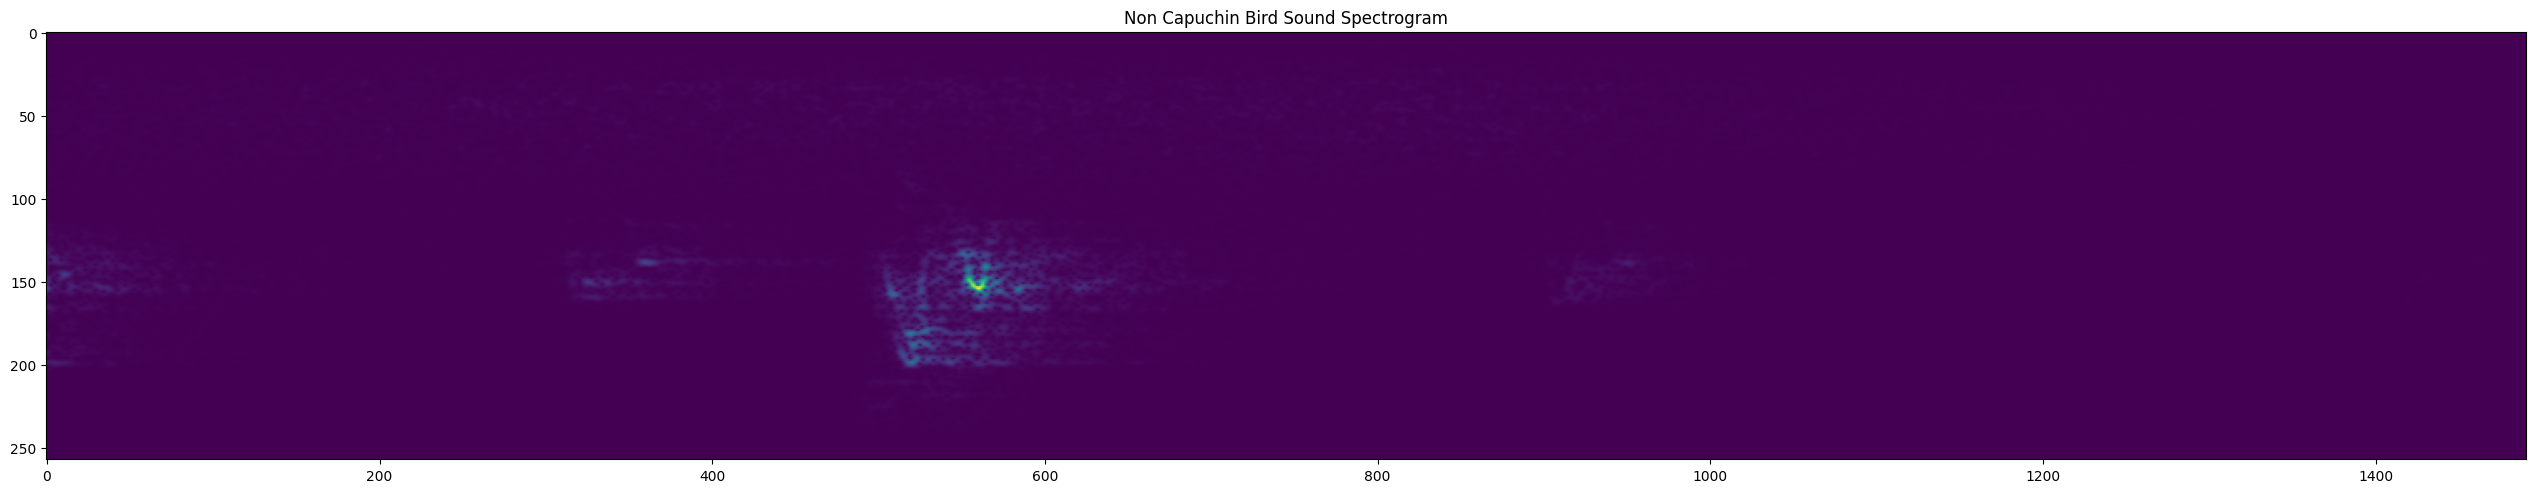

In [ ]:
plt.figure(figsize=(32,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.title("Non Capuchin Bird Sound Spectrogram")
plt.show()

Splitting in Training and Testing Data

In [ ]:
#Data pipeline
dataset = dataset.map(preprocess)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [ ]:
len(dataset)

51

In [ ]:
train = dataset.take(36)
test = dataset.skip(36).take(15)

Model Building and Traning on Audio files

In [ ]:
model = Sequential()

model.add(Conv2D(16, 3, activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, 3, activation = 'relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 32)                192620064 
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 192,622,577
Trainable params: 192,622,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=[Recall(),Precision()])

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 594s 14s/step - loss: 2.4652 - recall: 0.8235 - precision: 0.8182 - val_loss: 0.0568 - val_recall: 0.9831 - val_precision: 0.9355
Epoch 2/4
36/36 [==============================] - 497s 14s/step - loss: 0.1319 - recall: 0.9664 - precision: 0.9796 - val_loss: 0.0207 - val_recall: 0.9853 - val_precision: 0.9853
Epoch 3/4
36/36 [==============================] - 490s 14s/step - loss: 0.0184 - recall: 0.9870 - precision: 1.0000 - val_loss: 0.0022 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 481s 13s/step - loss: 0.0028 - recall: 1.0000 - precision: 1.0000 - val_loss: 5.8577e-04 - val_recall: 1.0000 - val_precision: 1.0000


In [ ]:
hist.history

{'loss': [2.4651505947113037,
  0.13190799951553345,
  0.01843648962676525,
  0.002814978826791048],
 'recall': [0.8235294222831726, 0.9664429426193237, 0.9870129823684692, 1.0],
 'precision': [0.8181818127632141, 0.9795918464660645, 1.0, 1.0],
 'val_loss': [0.056822530925273895,
  0.020664997398853302,
  0.0021878646221011877,
  0.0005857719806954265],
 'val_recall': [0.9830508232116699, 0.9852941036224365, 1.0, 1.0],
 'val_precision': [0.9354838728904724, 0.9852941036224365, 1.0, 1.0]}

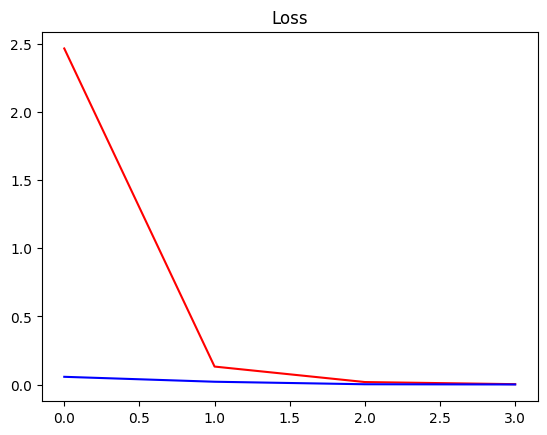

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

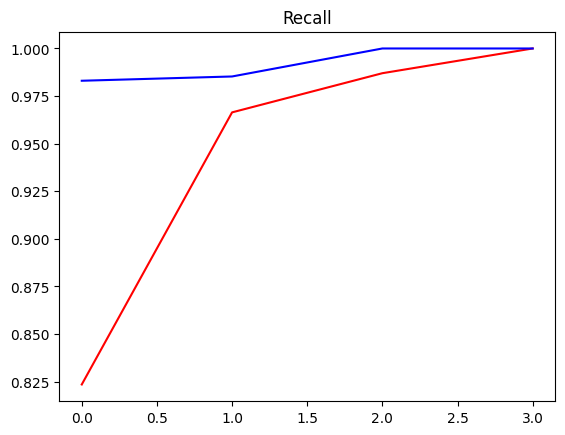

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

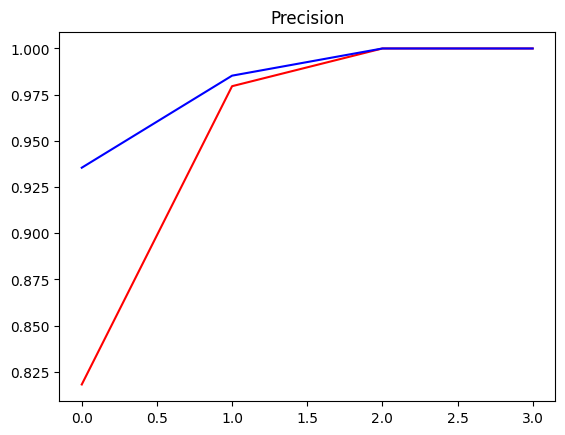

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
model.save('capuchin_audio_classifier_e4.h5')

Make Sample Prediction on a Clip

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()
y_test

array([1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [ ]:
prediction = model.predict(X_test)

1/1 [==============================] - 8s 8s/step


In [ ]:
y_hat = [1 if pre>0.5 else 0 for pre in prediction]
y_hat

[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]

In [ ]:
acc = sum([1 if y_hat[i]==y_test[i] else 0 for i in range(len(y_test))])/len(y_test)
print('Prediction Accuracy for this test case: ', acc)

Prediction Accuracy for this test case:  1.0


Loading the Model

In [ ]:
model = load_model('capuchin_audio_classifier_e2.h5')

Parsing Forest Recordings

In [ ]:
def load_mp3_16k_mono(filename):
  res = tfio.audio.AudioIOTensor(filename)

  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor, axis=1) / 2

  sample_rate = res.rate
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)

  wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
  return wav

In [ ]:
forest_recording = '/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Forest Recordings/recording_00.mp3'

In [ ]:
wav = load_mp3_16k_mono(forest_recording)

In [ ]:
wav

<tf.Tensor: shape=(2880666,), dtype=float32, numpy=
array([ 8.1433272e-12, -5.7019250e-12, -5.3486417e-12, ...,
       -1.1291276e-02, -1.4230422e-02, -3.0555837e-03], dtype=float32)>

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
len(audio_slices)

60

In [ ]:
samples.shape

(1, 48000)

Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
  sample = sample[0]
  zero_padding = tf.zeros([48000]-tf.shape(sample), dtype=tf.float32)
  wav = tf.concat([zero_padding, sample], 0)
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2) #Adding a channel dimension
  return spectrogram

In [ ]:
audio_slices = audio_slices.map(preprocess_mp3)

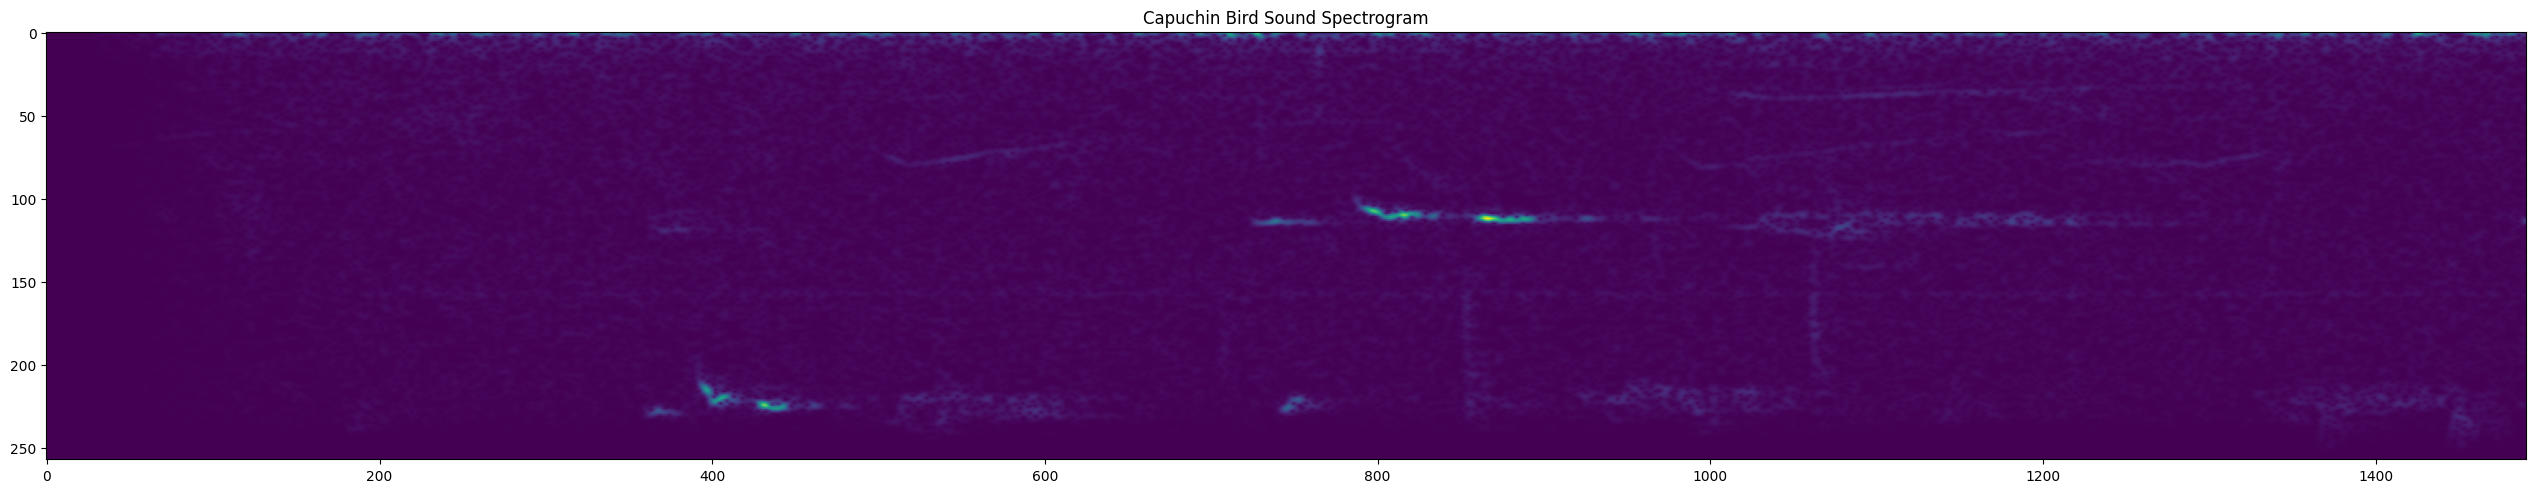

In [ ]:
spec = audio_slices.as_numpy_iterator().next()
plt.figure(figsize=(32,20))
plt.imshow(tf.transpose(spec)[0])
plt.title("Capuchin Bird Sound Spectrogram")
plt.show()

In [ ]:
audio_slices = audio_slices.batch(64)

In [ ]:
y_hat = model.predict(audio_slices)

1/1 [==============================] - 19s 19s/step


In [ ]:
y_hat = [1 if prediction > 0.99 else 0 for prediction in y_hat]
len(y_hat)

60

In [ ]:
y_hat = [key for key, group in groupby(y_hat)]
calls = tf.math.reduce_sum(y_hat).numpy()

In [ ]:
y_hat

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

Predictions for All Recordings

In [ ]:
forest_recording_folder = '/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Forest Recordings'

In [ ]:
tf.data.Dataset.list_files(forest_recording_folder+'/*.mp3').as_numpy_iterator().next()

b'/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Forest Recordings/recording_54.mp3'

In [ ]:
results = {}
for file_path in list(tf.data.Dataset.list_files(forest_recording_folder+'/*.mp3'))[:20]:
    wav = load_mp3_16k_mono(file_path)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    y_hat = model.predict(audio_slices)
    
    results[file_path.numpy()] = y_hat

1/1 [==============================] - 15s 15s/step


1/1 [==============================] - 10s 10s/step


1/1 [==============================] - 14s 14s/step


In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()

In [ ]:
postprocessed

{b'/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Forest Recordings/recording_51.mp3': 3,
 b'/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Forest Recordings/recording_91.mp3': 0,
 b'/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Forest Recordings/recording_99.mp3': 5,
 b'/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Forest Recordings/recording_88.mp3': 0,
 b'/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Forest Recordings/recording_41.mp3': 0,
 b'/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Forest Recordings/recording_32.mp3': 2,
 b'/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Forest Recordings/recording_47.mp3': 10,
 b'/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Forest Recordings/recording_58.mp3': 0,
 b'/content/drive/MyDrive/Bird Audio Classification/BirdAudioDataset/Forest Recordings/recording_67.mp3': 0,
 b'/content/drive/